# Implementing a tussock in the flow - the shallow water equation

Below, we implement the shallow water equations to study the effect of a plant tussock on the water flow on a tidal flat or in a river.

![Tussock](Images/Tussock_in_the_flow.png "Tussock")

We are going to start with the following precise formulation of Shallow water equations, which describe the change in velocity vectors $u$ and $v$ in the $x$ and $y$ dimension respectively, and their effect on local water height $h$:

$$
\begin{aligned}
\frac{\partial u}{\partial t}&= -g\frac{\partial o}{\partial x} -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial x} - \frac{g}{C_t^2} \frac{|\mathbf{u}|u}{h}\\
\frac{\partial v}{\partial t}&= -g\frac{\partial o}{\partial y} -u\frac{\partial v}{\partial y} - v\frac{\partial v}{\partial y} - \frac{g}{C_t^2} \frac{|\mathbf{u}|v}{h}\\
\frac{\partial h}{\partial t}&= -\frac{\partial uh}{\partial x} -\frac{\partial vh}{\partial y} \\
\end{aligned}
$$

Here $o = h + s$, where $s$ is the bottom elevation. In other words, $o$ is the vertical position of the water surface, $h$ is the water height relative to the bottom, and $s$ is the position of the bottom (e.g., the sediment).

The bottom friction is calculated using the Baptist equation, assuming that the vegetation is emergent:
$$
\begin{aligned}
C_t = \sqrt{\frac{1}{ C_b^{-2} + (2g)^{-1} C_d D_v h} }
\end{aligned}
$$

Below, we implement this model in Python

### Loading required modules

In [1]:
import numpy as np                    # The main computation library
import matplotlib.pyplot as plt       # The main plotting library
import matplotlib.patches as pt       # For drawing a rectangle
from matplotlib import cm             # Colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time                           # For the time function
import os as osx                      # For the "system" command

on=1;off=0;                           # Some macro definitions

### Parameter values are defined below
For values, see: http://www.engineeringtoolbox.com/mannings-roughness-d_799.html

In [2]:
# %% Basic Parameter values
g          = 9.8     # Gravity
A          = 0.001   # Turbulent diffusion term

# Vegetation roughness parameters
Cb        =  20.0    # Chezy friction coefficient for the bottom
Cd        =  2.0     # Chezy friction coefficient for the vegetation
Hv        =  0.6     # Vegetation height
kv        =  0.41    # Von Karman constant

# Hydrodynamic parameters
Depth      = 0.4     # Water depth
FlowY      = -0.3    # Initial flowrate of the water, also set as boundary condition

### Simulation settings 

In [3]:
dt         = 0.01    # The timestep
EndTime    = 100     # The simulation duration
NumPlots   = 100     # Number of times the graph is updated

LengthX    = 25.6    # Length of the landscape in the X dimension
LengthY    = 25.6    # Length of the landscape in the Y dimension

Periodic   = off     # Periodic boundary conditions, or continued flow boundaries

### Graphics settings

In [4]:
WinWidth   = 1440    # Width of the simulation window 
WinHeight  = 720     # Height of the simulation window

FlowMax    = 0.5     # The maximal flow rate in the graph colorbar

ArrowNrX   = LengthX-2   # Number of Arrows in the X direction
ArrowNrY   = LengthY-2   # Number of Arrows in the Y direction

### Patch parameters

In [5]:
PatchCenterX = 0.5
PatchCenterY = 0.75

# Size of the patch, and sharpness
k = 3; 
q = 20

###  Parameter calculations

In [6]:
dx = 0.2;     # Size of a gridcell in the x dimension
dy = 0.2;     # Size of a gridcell in the y dimension

NX = int(LengthX/dx)   # Number of Gridcells in the X direction
NY = int(LengthY/dy)   # Number of Gridcells in the Y direction

### Functions that calculate the derivatives

In [7]:
# Gradient operators, central difference scheme 
# The functions below adopt periodic boundary conditions by default

def d_dx(Z): # First order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    return (Zright - Zleft) / 2.0 / dx

def d_dy(Z): # First order derivative that assumes periodic boundary conditions
    Ztop  = np.roll(Z, 1, axis=1)
    Zbottom = np.roll(Z, -1, axis=1)
    return (Zbottom - Ztop) / 2.0 / dy

def d2_dxy2(Z): # Second order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    Ztop = np.roll(Z, 1, axis=1)
    Zbottom = np.roll(Z, -1, axis=1)    
    return (Zleft + Zright   - 2.0 * Z)/dx/dx + (Ztop  + Zbottom  - 2.0 * Z)/dy/dy

### Array definitions and initial values

In [8]:
# The water velocity u (x dimension) and v (y dimension) (m/s)
# and o - The height of the surface water layer (m)
u = np.zeros((NX, NY))
v = np.zeros((NX, NY))
o = np.zeros((NX, NY))
h = np.zeros((NX, NY))
s = np.zeros((NX, NY))
p = np.zeros((NX, NY))

v = v + FlowY
h = h + Depth

### Here a patch is defined

In [9]:
X, Y = np.mgrid[1:(NX+1):1, 1:(NY+1):1]
X = X/NX*LengthX; Y = Y/NY*LengthY

# Locations of the patch
Xp = LengthX*PatchCenterX; 
Yp = LengthY*PatchCenterY;

# Determining the values in the patch in general
D = np.sqrt( (X-Xp)**2 + (Y-Yp)**2) # Distance from patch center
F = k**q/(D**q+k**q)                # Biomass factor as a function of distance from center

# Assigning biomass and sediment with patch value.
p = F      # Plant biomass equals F
s = F*0.1  # Including a sediment layer
h = h-s    # Water is lowered where there is sediment, to maintain a flat water surface

### Main simulation

In [10]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=NumPlots); display(PB)

# Defining a storage containers us, vs and os for all frames
us=np.zeros((NX, NY, NumPlots))
vs=np.zeros((NX, NY, NumPlots))
os=np.zeros((NX, NY, NumPlots))

# Starting a timer:
start_time = time.time()

# We simulate the PDE with the finite difference method.
for j in range(NumPlots):

    for i in range(int(EndTime/dt/NumPlots)):
  
        # --- The equation for momentum conservation --------------------------------
        o = h + s 
  
        NetSpeed=np.sqrt(u*u+v*v)             # The net speed of the water
        Dv = 1.0*p
        Ct = np.sqrt(1.0/(1.0/(Cb*Cb)+1.0/(2.0*g)*Cd*Dv*Hv)) \
           + np.sqrt(g/kv)*np.log(np.maximum(h/Hv,1.0));
        b  = g/(Ct*Ct)*NetSpeed/h
    
        # Change in water velocity u in the X direction
        du = - g*d_dx(o) - u*d_dx(u) - v*d_dy(u) + A*d2_dxy2(u) - b*u;
        # Change in water velocity v in the Y direction
        dv = - g*d_dy(o) - u*d_dx(v) - v*d_dy(v) + A*d2_dxy2(v) - b*v;
  
        u = u + dt*du;                     # Update water velocity u and v
        v = v + dt*dv;                
  
        # --- Boundary conditions ---------------------------------------------------
        if(Periodic==off):  
            # Left           Right               Upper            Lower
            u[0,:]  = u[1,:];  u[NX-1,:] = u[NX-2,:];  u[:,0] = u[:,1];  u[:,NY-1] = u[:,NY-2]; 
            v[0,:]  = v[1,:];  v[NX-1,:] = v[NX-2,:];  v[:,0] = v[:,1] ; v[:,NY-1] = FlowY; 

        # --- The equation for mass conservation ------------------------------------
        dh = - (d_dx(h*u) + d_dy(h*v))     # Change in water depth
        h = h + dt*dh;                     # Update water depth 
  
        # --- Boundary conditions ---------------------------------------------------
        if(Periodic==off):  
            # Left           Right               Upper            Lower
            h[0,:]  = h[1,:];  h[NX-1,:] = h[NX-2,:];  h[:,0]  = Depth;  h[:,NY-1] = h[:,NY-2]; 
            
    # We store the state of the system for NumPlot different times.
    us[:,:,j] = u
    vs[:,:,j] = v
    os[:,:,j] = h+s  
    
    PB.value += 1 # signal to increment the progress bar
        
    if np.isnan(u.sum()) or np.isnan(v.sum()) or np.isnan(h.sum()): break
        
    # End of the loop => Wrapping up the simulation          

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    

if np.isnan(u.sum()) or np.isnan(v.sum()) or np.isnan(h.sum()):   
    print("\n NaN detected!!!! \n"); 
    osx.system("say The model has TOTALLY and UTTERLY crashed!")  
else:
    print(" Finished after %1.0f seconds" % (elapsed_time))    
    osx.system("say Finished after %1.0f seconds" % (elapsed_time))

Progress :


FloatProgress(value=0.0)

 Finished after 20 seconds


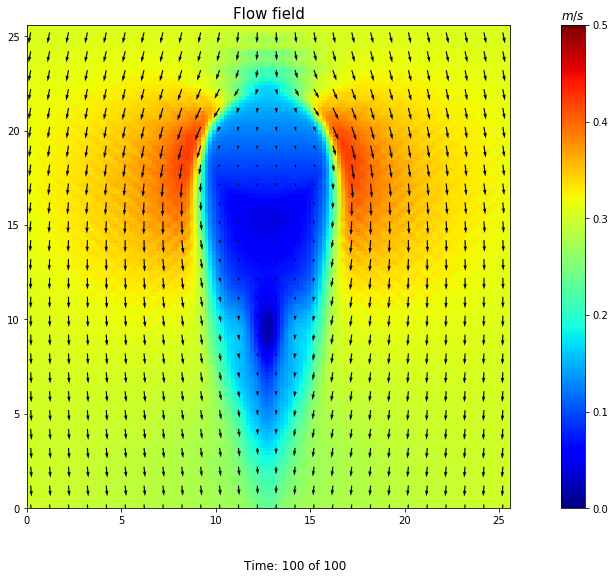

In [11]:
# %% Setting up the figures with two panels for A and M
fig, axs = plt.subplots(1, 1, figsize=(10, 9))

# Printing time progress
text=fig.suptitle("Time: %1.0f of %1.0f " % (EndTime, EndTime), 
            y=0.05, fontsize=12);

NetSpeed=np.sqrt(u**2+v**2)

im1 = axs.imshow(NetSpeed.T, cmap=cm.jet, clim=(0.0,FlowMax), 
                 origin="lower", extent=[0,LengthX,0,LengthY])
axs.set_title('Flow field', fontsize=15)

divider = make_axes_locatable(axs)
cax = divider.new_horizontal(size="5%", pad=0.7, pack_start=False)
fig.add_axes(cax)
cb1=fig.colorbar(im1, cax=cax)
cb1.ax.set_title('$m/s$')

# the quiver (arrow) plot
ax = int(NX/ArrowNrX)
ay = int(NY/ArrowNrY)

Q = axs.quiver( X[::ax, ::ay], Y[::ax, ::ay], u[::ax, ::ay], v[::ax, ::ay], 
                cmap=cm.jet, clim=(0,0.6))

In [12]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global us,vs,os
    NetSpeed=np.sqrt(us[:,:,i]**2+vs[:,:,i]**2)
    im1.set_data(NetSpeed.T)
    Q.set_UVC(u[::ax, ::ay], v[::ax, ::ay])    
    text.set_text("Time: %1.0f of %1.0f " % (i/NumPlots*EndTime, EndTime))
    return im1,

ani = animation.FuncAnimation(fig, updatefig,
                              interval=100, frames = NumPlots, repeat=False, blit=True)  

In [13]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [14]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('ShallowWaterTussuck.mp4', writer=writer)

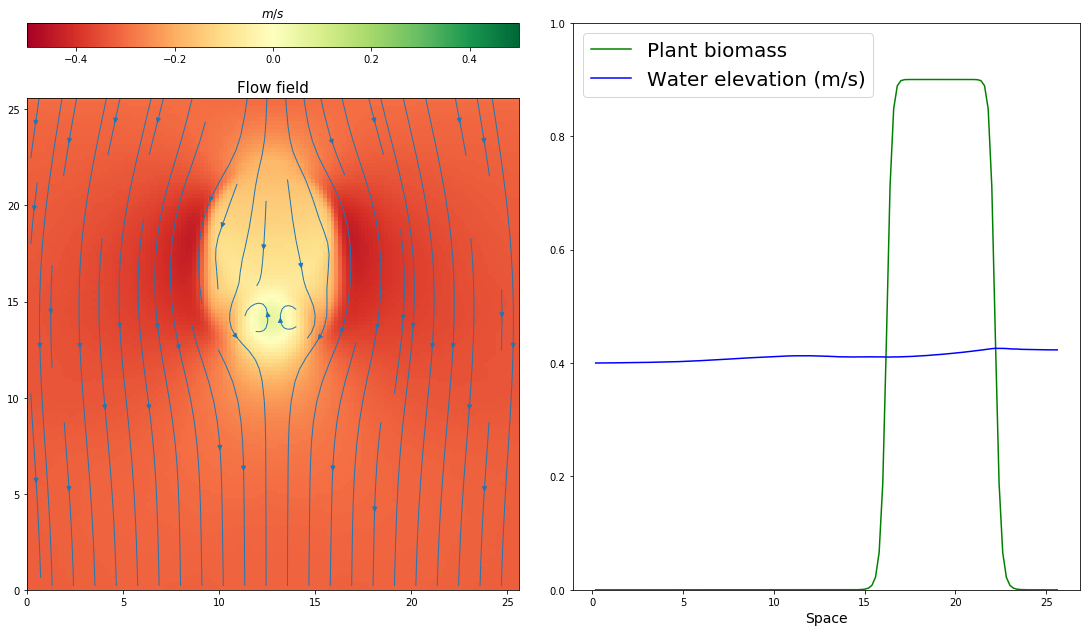

In [15]:
PlotTime = 30

PlotNr = int(PlotTime/EndTime*NumPlots)

# %% Setting up the figures with two panels for A and M
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

fig.canvas.set_window_title("Musselbed pattern formation model")
plt.tight_layout(pad=3.0, w_pad=1.5, h_pad=1.0 )     # reducing margin size

u=us[:,:,PlotNr-1]
v=vs[:,:,PlotNr-1]
o=os[:,:,PlotNr-1]

NetSpeed=v; #np.sqrt(u**2+v**2)
Xl = np.arange(0,LengthX,dx)+dx
Yl = np.arange(0,LengthY,dy)+dy

im1 = ax1.imshow(NetSpeed.T, cmap='RdYlGn', clim=(-FlowMax,FlowMax), 
                 origin="lower", extent=[0,LengthX,0,LengthY])
ax1.set_title('Flow field', fontsize=15)

# The colorbar
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=False)
fig.add_axes(cax)
cb1=fig.colorbar(im1, cax=cax, orientation='horizontal')
cb1.ax.set_title('$m/s$')

# the quiver (arrow) plot
ax = int(NX/16)
ay = int(NY/16)

f = ax1.streamplot(Y[1, :], X[:, 1], u.T, v.T, density=0.8, 
                   linewidth=1, cmap='autumn')
ax1.axis('scaled')
ax1.add_patch(pt.Rectangle( (NX*0.375, NY*0.6875), NX*0.25, NY*0.125, fill=False) )

# The second plot
pp=(p>0.0)*Hv  # A precalculation

line1 = ax2.plot(Yl,p[int(NX/2),:]*0.9, 'g', label=f'Plant biomass')
line2 = ax2.plot(Yl,o[int(NX/2), :], 'b', label=f'Water elevation (m/s)')
ax2.set_ylim([0,1])

ax2.set_xlabel('Space', fontsize=14)
ax2.legend(fontsize=20)

plt.show()

![Tussock](Images/Tussock_in_the_flow.png "Tussock")

© Johan van de Koppel, NIOZ-Yerseke 2018